# Analysis

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import itertools
import random

In [2]:
grammars = pd.read_csv("grammars.csv")
grammars.head()

,name,files
0,abnf,./abnf/Abnf.g4
1,agc,./agc/agc.g4
2,algol60,./algol60/algol60.g4
3,antlr3,./antlr3/ANTLRv3.g4
4,antlr4,"./antlr4/ANTLRv4Parser.g4,./antlr4/ANTLRv4Lexe..."


In [16]:
grammars = pd.read_csv("grammars-with-metrics-1.csv")
grammars.head()
len(grammars)

199

Text(0.5, 1.0, 'Distribution of grammar sizes')

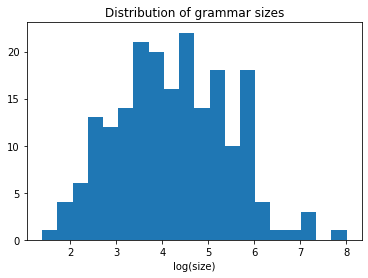

In [17]:
def grammar_size_measure(grammars):
    return np.log(grammars["VAR"])


sizes = grammar_size_measure(grammars)
plt.hist(sizes, bins=20)
plt.xlabel("log(size)")
plt.title("Distribution of grammar sizes")

In [19]:
sizes = ["small", "medium", "large"]

def partition(grammars):
    measures = grammar_size_measure(grammars)
    mean = measures.mean()
    std_dev = measures.std()
    
    def label(size):
        if size < mean - std_dev:
            return "small"
        elif mean - std_dev <= size < mean + std_dev:
            return "medium"
        else: # mean + std_dev <= size
            return "large"
    
    return grammars.assign(size = measures.map(label))

labeled = partition(grammars)
# uncomment to reproduce file
labeled.to_csv("grammars-with-size-1.csv", index=False)

In [20]:
grammars_per_size_category = 12

grammars_to_examine = [labeled[labeled["size"] == s].sample(grammars_per_size_category) for s in sizes]

In [11]:
repetitions = np.arange(5)
dependent_variables = ["MCC", "HAL"]
similarity_thresholds = [0.001, 0.25, 0.5, 0.75, 1.0]

def generate_experiments(grammars):
    pairs = list(itertools.combinations(grammars.index, 2))
    to_use = random.sample(pairs, len(similarity_thresholds) * len(repetitions) * len(dependent_variables))
    ids1, ids2 = map(list, zip(*to_use))
    names1 = grammars["name"].loc[ids1].values.reshape((-1, 1))
    names2 = grammars[["name", "size"]].loc[ids2]
    grammar_pairs = np.hstack((names1, names2))
    other_cols = list(itertools.product(repetitions, dependent_variables, similarity_thresholds))
    grammar_pairs_plus = np.hstack([grammar_pairs, other_cols])
    
    return pd.DataFrame(grammar_pairs_plus, columns=["name1", "name2", "size", "repetition", "dependent_variable", "similarity_threshold"])

experiments = pd.concat(map(generate_experiments, grammars_to_examine), ignore_index=True)

In [15]:
# uncomment to reproduce file
# warning: is randomly generated so it won't be the same
experiments.to_csv("experiments-1.csv", index=False)